In [4]:
import time
import itertools as it

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
from IPython import display

from Node.functions import *
from Node.Node import Control_node
from Plant.Plant import Plant

In [141]:
behav_size = 1
sigmoid_k = 2000
sigmoid_b = 10
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
# behavioral matrix (maps previous behavior to future behavior commands - how should I behave?)
B1 = np.random.rand(1, behav_size)
B2 = np.random.rand(1, behav_size)

# state/system matrix (maps previous state to future state - how will others behave (give past behaviors)?)
A1 = np.random.rand(1, behav_size)
A2 = np.random.rand(1, behav_size)

# reference matrix (how do I expect/want others to behave? target values)
R1 = np.random.rand(1, behav_size)
R2 = np.random.rand(1, behav_size)

# Initial behavior
behav_1 = np.random.rand(1, behav_size)
behav_2 = np.random.rand(1, behav_size)

# transition matrix (maps control signal and previous state to current state - what behaviors do I enact given my intentions?)
T1 = np.array([0.25])
T2 = np.array([0.25])

color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]

# get the state observation (behaviors of others)
def sense(inputs):
    perception = inputs
    return perception

# contrast reference with observations (and potentially incorporate predictions from internal model)
def compare(sensory_signal, reference, prediction):
    error = reference - sensory_signal
    return error

# generate a control signal
def control(error, behavioral_model, previous_output):
    control_signal = chaotic_controller(behavioral_model, 0.01, error)
    return control_signal

# dictates how control commands determine state transitions - i.e. behaviors
def transition(control_signal, transition_matrix, state):
    new_state = (transition_matrix * control_signal) + state
    new_state[new_state > 1] = 1
    new_state[new_state < 0] = 0
    return new_state


# adjusts behavioral model to get closer to behavior given 
def control_update(error, behavioral_model, previous_output):
    # LMS algorithm
    learning_rate = 0.0
    #behavioral_model = behavioral_model + learning_rate * error * previous_output
    return behavioral_model

# adjusts reference given error
def reference_update_true(reference, error):
    k = 0.1
    reference = reference - (error * k)
    reference[reference > 1] = 1
    reference[reference < 0] = 0
    return reference

# does not adjust reference
def reference_update_false(reference, error):
    k = 0
    reference = reference + (error * k)
    return reference

def reference_update_sigmoid(reference, error):
    # reference = (matrix_sigmoid(error)-1)*(R1) + matrix_sigmoid(error)*(reference + error)
    sqr_error = np.square(error)
    reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
    # k = 0.1
    # k =  zero_sigmoid(error)
    # reference = reference - (error * k)
    return reference

# generate predictions on next state
def imc(system_estimate, previous_state, behavioral_model, previous_output):
    # actual estimate
    state = (system_estimate * previous_state) + (behavioral_model * previous_output)
    return state

# adjust system estimate to infer observations given my behavior
def imc_update(inputs, system_estimate, previous_behavior, behavioral_model, previous_state, learning_rate):
    # actual estimate
    #curr_system_est = (system_estimate @ previous_state) + (behavioral_model @ previous_behavior)
    #error = curr_system_est - inputs
    #learning_rate = 0.01
    #system_estimate = system_estimate + learning_rate * error * previous_behavior
    return system_estimate

plant1 = Plant(transition_matrix=T1, transition_function=transition, state=behav_1)
plant2 = Plant(transition_matrix=T2, transition_function=transition, state=behav_2)

conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
system_estimate=A2, reference=R2, init_behavior=behav_2)

sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
system_estimate=A1, reference=R1, init_behavior=behav_1)

Seed was: 937

 Sigmoid Model Agents (Error Relative to Expectation)


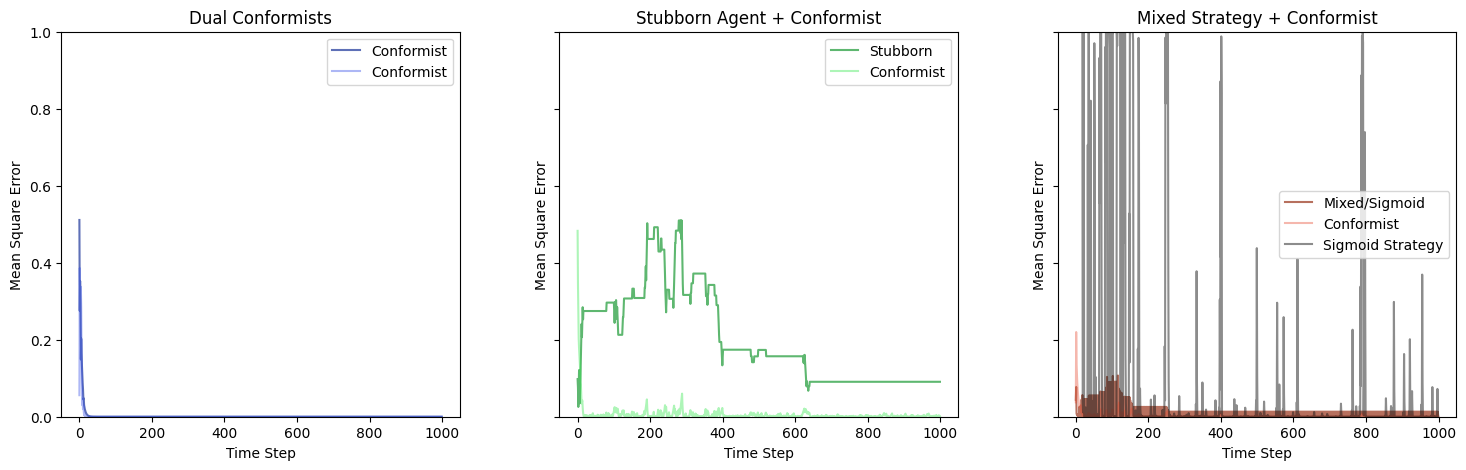

In [142]:
seed = random.randrange(1000)
# seed = 378
np.random.seed(seed)
print("Seed was:", seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
agents1 = [conformist2, stubborn, sigmoid]
agents2 = [conformist1, conformist1, conformist1]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
trials = 1000
time = [i for i in range(trials)]

color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]

for ix, param in enumerate(param_vals):
    # experiments
    conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
    system_estimate=A2, reference=R2, init_behavior=behav_2)

    sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
    controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
    system_estimate=A1, reference=R1, init_behavior=behav_1)

    plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
    plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))

    b1 = np.random.rand(1, behav_size)
    b2 = np.random.rand(1, behav_size)

    agent1 = agents1[param%3]
    agent2 = agents2[0]
    agent1_error = []
    agent2_error = []
    sigmoid_value = []
    for t in range(trials):
        color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
        color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
        #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
        #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
        b1_control = agent1.go(b2)   
        b2_control = agent2.go(b1)

        # agent1_control.append(agent1.get_output())
        # agent2_control.append(agent2.get_output())

        b1 = plant1.transition(b1_control)
        b2 = plant2.transition(b2_control)
        
        # agent1_behaviors.append(b1)
        # agent2_behaviors.append(b2)

        # agent1_error.append(np.absolute(agent1.get_error()))
        # agent2_error.append(np.absolute(agent2.get_error()))
        agent1_error.append(np.sum(np.square(agent1.get_error()[0]))/len(agent1.get_error()[0]))
        agent2_error.append(np.sum(np.square(agent2.get_error()[0]))/len(agent2.get_error()[0]))
        if agents_label[param] == "Mixed/Sigmoid": 
          sqr_error = np.square(agent2.get_error()[0])
          sigmoid_value.append(shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))

        # agent1_reference.append(agent1.get_reference()[0])
        # agent2_reference.append(agent2.get_reference()[0])

    ai = tups[ix][1]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    if agents_label[param] == "Mixed/Sigmoid": 
      ax[ai].plot(time, sigmoid_value, color=color_black, label="Sigmoid Strategy")
    #   print(sigmoid_value)
    if agents_label[param%3] == "Conformist":
      ax[ai].set_title('Dual Conformists')
    elif agents_label[param%3] == "Stubborn":
      ax[ai].set_title('Stubborn Agent + Conformist')
    else:
      ax[ai].set_title('Mixed Strategy + Conformist')
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    ax[ai].set_xlabel("Time Step")

print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()

Seed was: 63
Mean Conformist Expectation Error at final timestep:  1.4077303562170687e-31
Mean Conformist Expectation Error at final timestep: 1.4074295237028064e-31
Mean Conformist Preference Error at final timestep:  0.16241302622423295
Mean Conformist Preference Error at final timestep: 0.15782230220738547
---
Mean Conformist Expectation Error at final timestep:  0.012154156348808152
Mean Stubborn Expectation Error at final timestep: 0.10450693890450052
Mean Conformist Preference Error at final timestep:  0.17763541330171442
Mean Stubborn Preference Error at final timestep: 0.10450693890450052
---
Mean Conformist Expectation Error at final timestep:  0.009181126082442034
Mean Mixed/Sigmoid Expectation Error at final timestep: 0.11783454719380909
Mean Conformist Preference Error at final timestep:  0.1778030165416074
Mean Mixed/Sigmoid Preference Error at final timestep: 0.13433442123339248
---

 Sigmoid Model Agents (Error Relative to Expectation)


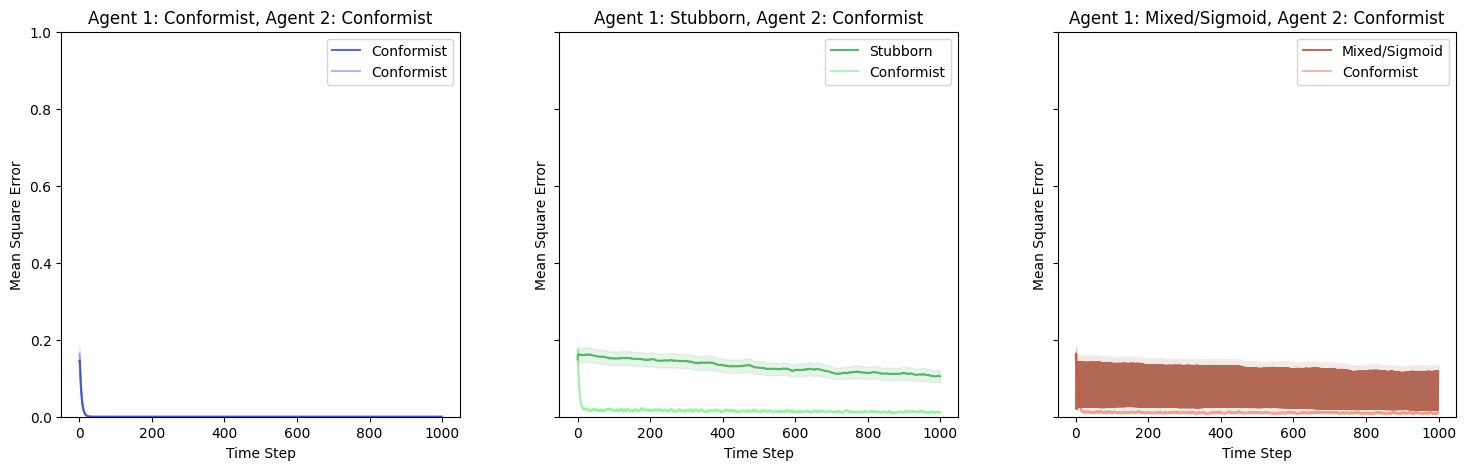

In [143]:
seed = random.randrange(1000)
# seed = 37
np.random.seed(seed)
print("Seed was:", seed)
w = 6; h = 5
ncols = 3
nrows = 1
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
experiments = 400
trials = 1000
time = [i for i in range(trials)]


color1 = [0.1,0.2,0.6, 0.7]
color1c = [0.2,0.3,0.9, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.6,0.2,0.1, 0.7]
color3c = [0.9,0.3,0.2, 0.4]
colors = [color1,color2,color3]
colors_c = [color1c,color2c,color3c]
color_black = [0.1,0.1,0.1,0.5]


# the type of experiment
for ix, param in enumerate(param_vals):
    agent1_pref_errors = []
    agent2_pref_errors = []
    agent1_errors = []
    agent2_errors = []
    agent1_raw_errors = []
    agent2_raw_errors = []
    agent1_behaviorss = []
    agent2_behaviorss = []
    ratio1 = []
    ratio2 = []
    # the experiments
    for e in range(experiments):
      behav_1 = np.random.rand(1,behav_size)
      behav_2 = np.random.rand(1,behav_size)
      R1 = np.random.rand(1,behav_size)
      R2 = np.random.rand(1,behav_size)
      b1 = np.random.rand(1,behav_size)
      b2 = np.random.rand(1,behav_size)
      conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
      system_estimate=A2, reference=R2, init_behavior=behav_2)

      conformist2 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      stubborn = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_false,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
      plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))
      agents1 = [conformist2, stubborn, sigmoid]
      agents2 = [conformist1, conformist1, conformist1]

      # b1 = np.random.rand(1, 10)
      # b2 = np.random.rand(1, 10)

      agent1 = agents1[param]
      agent2 = agents2[0]
      agent1_error = []
      agent2_error = []
      agent1_pref_error = []
      agent2_pref_error = []
      agent1_raw_error = []
      agent2_raw_error = []
      sigmoid_value = []
      agent1_behaviors = []
      agent2_behaviors = []
      # agent1_control = []
      # agent2_control = []
      # agent1_reference = []
      # agent2_reference = []
      # the time steps
      for t in range(trials):
          color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
          color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
          #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
          #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
          # print("reference: ", agent1.get_reference())
          # print("observation: ", b2)
          agent1_pref_error.append(np.sum(np.square(R1-b2))/behav_size)
          agent2_pref_error.append(np.sum(np.square(R2-b1))/behav_size)
          # if agents_label[param] == "Stubborn":
          #   print("R1 :", R1)
          #   print("agent 1 pref error: ", np.sum(np.absolute(R1-b2))/len(agent1.get_reference()[0]))
          b1_control = agent1.go(b2)   
          b2_control = agent2.go(b1)

          agent1_behaviors.append(b1)
          agent2_behaviors.append(b2)

          # agent1_error.append(np.absolute(agent1.get_error()))
          # agent2_error.append(np.absolute(agent2.get_error()))
          agent1_raw_error.append(agent1.get_error()[0][0])
          agent2_raw_error.append(agent2.get_error()[0][0])

          # agent1_control.append(agent1.get_output())
          # agent2_control.append(agent2.get_output())

          b1 = plant1.transition(b1_control)
          b2 = plant2.transition(b2_control)
          
          # agent1_behaviors.append(b1)
          # agent2_behaviors.append(b2)

          # agent1_error.append(np.absolute(agent1.get_error()))
          # agent2_error.append(np.absolute(agent2.get_error()))
          agent1_error.append(np.sum(np.square(agent1.get_error())[0])/behav_size)
          agent2_error.append(np.sum(np.square(agent2.get_error())[0])/behav_size)
          # if agents_label[param] == "Stubborn":
          #   print("agent1 :", agent1.get_reference())
          #   print("stubborn :", stubborn.get_reference())
          #   print("agent 1 error: ", np.sum(np.absolute(agent1.get_error())[0])/len(agent1.get_reference()[0]))
          #   print("agent1_error :", agent1_error)
          #   print("---")
            

        # agent1_reference.append(agent1.get_reference()[0])
        # agent2_reference.append(agent2.get_reference()[0])
      agent1_errors.append(agent1_error)
      agent2_errors.append(agent2_error)
      agent1_pref_errors.append(agent1_pref_error)
      agent2_pref_errors.append(agent2_pref_error)
      agent1_raw_errors = []
      agent2_raw_errors = []
      agent1_behaviorss = []
      agent1_behaviorss = []
      # if agents_label[param] == "Stubborn":
      #    print("agent1_errors: ", agent1_errors)
      #    print("agent1_pref_errors: ", agent1_pref_errors)
      dx = 1
      # b1_flat = [i[0] for i in agent1_control]
      # b2_flat = [i[0] for i in agent2_control]
      b1_flat = [i[0][0]for i in agent1_behaviors]
      b2_flat = [i[0][0]for i in agent2_behaviors]
      # d_behav1 = abs(np.gradient(b1_flat, dx))
      # d_behav2 = abs(np.gradient(b2_flat, dx))
      d_behav1 = np.insert(np.diff(b1_flat, dx), 0, 0)
      d_behav2 = np.insert(np.diff(b2_flat, dx), 0, 0)
      agent1_raw_error.insert(-1, 1)
      agent2_raw_error.insert(-1, 1)
      agent1_raw_error_shifted = agent1_raw_error[1:]
      agent2_raw_error_shifted = agent2_raw_error[1:]
      ratio1.append(abs(d_behav1/agent2_raw_error_shifted))
      ratio2.append(abs(d_behav2/agent1_raw_error_shifted))

    error1_mat = np.array(agent1_errors)
    error2_mat = np.array(agent2_errors)
    pref_error1_mat = np.array(agent1_pref_errors)
    pref_error2_mat = np.array(agent2_pref_errors)

    mean_error1 = np.average(error1_mat, axis=0)
    mean_error2 = np.average(error2_mat, axis=0)
    mean_pref_error1 = np.average(pref_error1_mat, axis=0)
    mean_pref_error2 = np.average(pref_error2_mat, axis=0)
    std_error1  = error1_mat.std(0)
    std_error2  = error2_mat.std(0)
    std_pref_error1  = pref_error1_mat.std(0)
    std_pref_error2  = pref_error2_mat.std(0)
    t = [n for n in range(trials)]
    ci1 = 2.96 * std_error1/np.sqrt(trials)
    ci2 = 2.96 * std_error2/np.sqrt(trials)
    pref_ci1 = 1.96 * std_pref_error1/np.sqrt(trials)
    pref_ci2 = 1.96 * std_pref_error2/np.sqrt(trials)

    upper1 = mean_error1+ci1
    lower1 = mean_error1-ci1
    upper1 = upper1.reshape(trials,)
    lower1 = lower1.reshape(trials,)
    upper2 = mean_error2+ci2
    lower2 = mean_error2-ci2
    upper2 = upper2.reshape(trials,)
    lower2 = lower2.reshape(trials,)

    pref_upper1 = mean_pref_error1+pref_ci1
    pref_lower1 = mean_pref_error1-pref_ci1
    pref_upper1 = pref_upper1.reshape(trials,)
    pref_lower1 = pref_lower1.reshape(trials,)
    pref_upper2 = mean_pref_error2+pref_ci2
    pref_lower2 = mean_pref_error2-pref_ci2
    pref_upper2 = pref_upper2.reshape(trials,)
    pref_lower2 = pref_lower2.reshape(trials,)
    
    ai = tups[ix][1]
    color = colors[param]
    color_c = colors_c[param]
    # plots
    ax[ai].plot(time, mean_error1, color=color,label=agents_label[param])
    ax[ai].plot(time, mean_error2, color=color_c, label="Conformist")
    ax[ai].fill_between(t, lower1, upper1, color=color, alpha=.1)
    ax[ai].fill_between(t, lower2, upper2, color=color_c, alpha=.1)
    # ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    # ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    ax[ai].set_title('Agent 1: {}, Agent 2: Conformist'.format(agents_label[param]))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    ax[ai].set_xlabel("Time Step")
    # ax[ai].tick_params(axis='y')
    print("Mean Conformist Expectation Error at final timestep: ", mean_error2[-1])
    print("Mean {} Expectation Error at final timestep: {}".format(agents_label[param], mean_error1[-1]))
    print("Mean Conformist Preference Error at final timestep: ", mean_pref_error2[-1])
    print("Mean {} Preference Error at final timestep: {}".format(agents_label[param], mean_pref_error1[-1]))
    print("---")

print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()

### Aggregate Complexity by Sigmoid Parameterization


 Sigmoid Model Agents (Error Relative to Expectation)


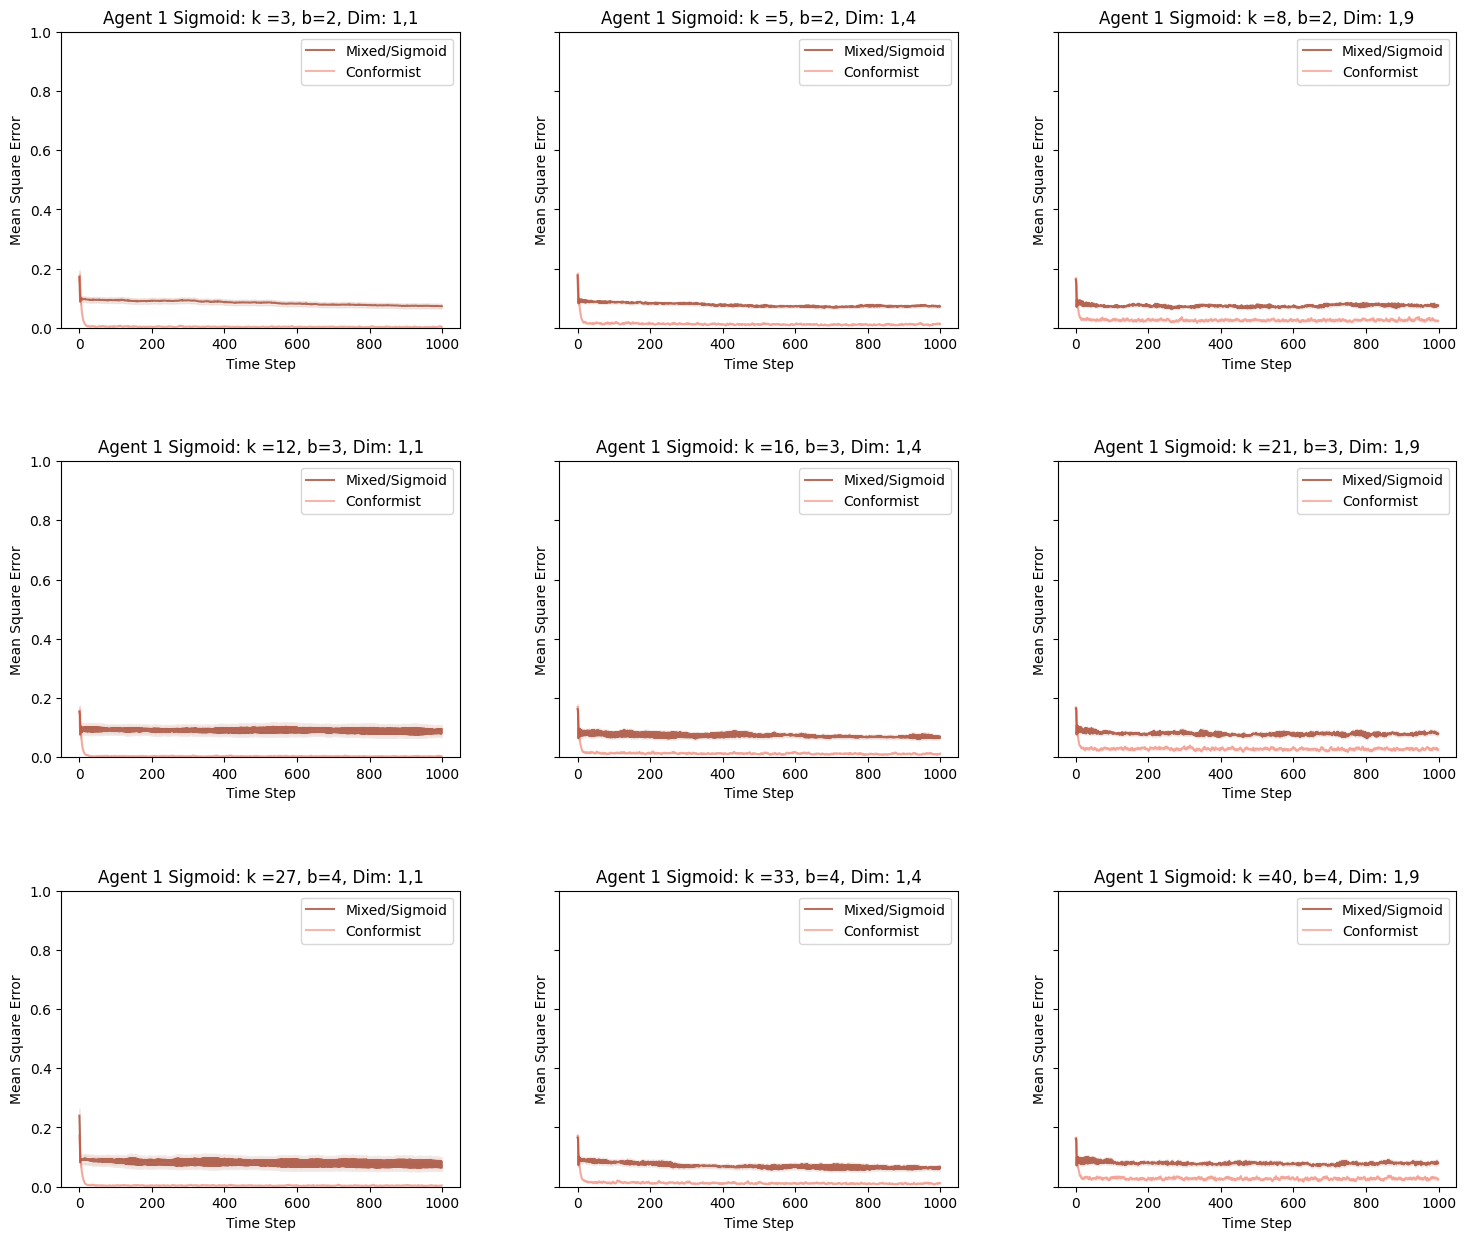

In [75]:
# np.random.seed(37)
w = 6; h = 5
ncols = 3
nrows = 3
param_vals = [i for i in range(0, ncols*nrows)]
tups = list(it.product(range(nrows), range(ncols)))
agents_label = ["Conformist", "Stubborn", "Mixed/Sigmoid"]
fig, ax = plt.subplots(nrows, ncols, figsize=(w*ncols, h*nrows), dpi=100,
                       sharey=True)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.45)
experiments = 200
trials = 1000
time = [i for i in range(trials)]


color1 = [0.6,0.2,0.1, 0.7]
color1c = [0.9,0.3,0.2, 0.4]
color2 = [0.1,0.6,0.2, 0.7]
color2c = [0.2,0.9,0.3, 0.4]
color3 = [0.1,0.2,0.6, 0.7]
color3c = [0.2,0.3,0.9, 0.4]
colors = [color1,color1,color1]
colors_c = [color1c,color1c,color1c]


# the type of experiment
for ix, param in enumerate(param_vals):
    agent1_pref_errors = []
    agent2_pref_errors = []
    agent1_errors = []
    agent2_errors = []
    # the experiments
    behav_size = ((param%3)+1)*((param%3)+1)
    sigmoid_k = ((param+3)*(param+3))//3
    sigmoid_b = (param//3)+2
    for e in range(experiments):
      behav_1 = np.random.rand(1,behav_size)
      behav_2 = np.random.rand(1,behav_size)
      R1 = np.random.rand(1,behav_size)
      R2 = np.random.rand(1,behav_size)
      b1 = np.random.rand(1,behav_size)
      b2 = np.random.rand(1,behav_size)
      B1 = np.random.rand(1, behav_size)
      B2 = np.random.rand(1, behav_size)


      conformist1 = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_true,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B2, 
      system_estimate=A2, reference=R2, init_behavior=behav_2)

      def reference_update_sigmoid(reference, error):
        sqr_error = np.square(error)
        reference = shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b)*(reference - error) + (1-shifted_sigmoid(sqr_error, sigmoid_k, sigmoid_b))*(R1)
        return reference

      sigmoid = Control_node(sensor=sense, comparator=compare, control_update=control_update, reference_update=reference_update_sigmoid,
      controller = control, internal_model=imc, internal_model_update=imc_update, behavioral_model=B1, 
      system_estimate=A1, reference=R1, init_behavior=behav_1)

      plant1 = Plant(transition_matrix=T1, transition_function=transition, state=np.random.rand(1, behav_size))
      plant2 = Plant(transition_matrix=T2, transition_function=transition, state=np.random.rand(1, behav_size))
      agents1 = [conformist2, stubborn, sigmoid]
      agents2 = [conformist1, conformist1, conformist1]

      # b1 = np.random.rand(1, 10)
      # b2 = np.random.rand(1, 10)

      agent1 = agents1[2]
      agent2 = agents2[0]
      agent1_error = []
      agent2_error = []
      agent1_pref_error = []
      agent2_pref_error = []
      # the time steps
      for t in range(trials):
          color1 = [0.1,0.2,0.8, (t+1)/(trials+1)]
          color2 = [0.1,0.8,0.2, (t+1)/(trials+1)]
          #pl.scatter(agent1.get_reference()[0],-0.03, c=color1, edgecolors=[0.8,0.1,0.1, color1[1]])
          #pl.scatter(agent2.get_reference()[0],0, c=color2, edgecolors=[0.8,0.1,0.1, color2[3]], linewidth=1.5)
          # print("reference: ", agent1.get_reference())
          # print("observation: ", b2)
          agent1_pref_error.append(np.sum(np.square(R1-b2))/behav_size)
          agent2_pref_error.append(np.sum(np.square(R2-b1))/behav_size)
          # if agents_label[param] == "Stubborn":
          #   print("R1 :", R1)
          #   print("agent 1 pref error: ", np.sum(np.absolute(R1-b2))/len(agent1.get_reference()[0]))
          b1_control = agent1.go(b2)   
          b2_control = agent2.go(b1)

          # agent1_control.append(agent1.get_output())
          # agent2_control.append(agent2.get_output())

          b1 = plant1.transition(b1_control)
          b2 = plant2.transition(b2_control)
          
          # agent1_behaviors.append(b1)
          # agent2_behaviors.append(b2)

          # agent1_error.append(np.absolute(agent1.get_error()))
          # agent2_error.append(np.absolute(agent2.get_error()))
          agent1_error.append(np.sum(np.square(agent1.get_error())[0])/behav_size)
          agent2_error.append(np.sum(np.square(agent2.get_error())[0])/behav_size)
          # if agents_label[param] == "Stubborn":
          #   print("agent1 :", agent1.get_reference())
          #   print("stubborn :", stubborn.get_reference())
          #   print("agent 1 error: ", np.sum(np.absolute(agent1.get_error())[0])/len(agent1.get_reference()[0]))
          #   print("agent1_error :", agent1_error)
          #   print("---")
            

        # agent1_reference.append(agent1.get_reference()[0])
        # agent2_reference.append(agent2.get_reference()[0])
      agent1_errors.append(agent1_error)
      agent2_errors.append(agent2_error)
      agent1_pref_errors.append(agent1_pref_error)
      agent2_pref_errors.append(agent2_pref_error)
      # if agents_label[param] == "Stubborn":
      #    print("agent1_errors: ", agent1_errors)
      #    print("agent1_pref_errors: ", agent1_pref_errors)

    error1_mat = np.array(agent1_errors)
    error2_mat = np.array(agent2_errors)
    pref_error1_mat = np.array(agent1_pref_errors)
    pref_error2_mat = np.array(agent2_pref_errors)

    mean_error1 = np.average(error1_mat, axis=0)
    mean_error2 = np.average(error2_mat, axis=0)
    mean_pref_error1 = np.average(pref_error1_mat, axis=0)
    mean_pref_error2 = np.average(pref_error2_mat, axis=0)
    std_error1  = error1_mat.std(0)
    std_error2  = error2_mat.std(0)
    std_pref_error1  = pref_error1_mat.std(0)
    std_pref_error2  = pref_error2_mat.std(0)
    t = [n for n in range(trials)]
    ci1 = 2.96 * std_error1/np.sqrt(trials)
    ci2 = 2.96 * std_error2/np.sqrt(trials)
    pref_ci1 = 1.96 * std_pref_error1/np.sqrt(trials)
    pref_ci2 = 1.96 * std_pref_error2/np.sqrt(trials)

    upper1 = mean_error1+ci1
    lower1 = mean_error1-ci1
    upper1 = upper1.reshape(trials,)
    lower1 = lower1.reshape(trials,)
    upper2 = mean_error2+ci2
    lower2 = mean_error2-ci2
    upper2 = upper2.reshape(trials,)
    lower2 = lower2.reshape(trials,)

    pref_upper1 = mean_pref_error1+pref_ci1
    pref_lower1 = mean_pref_error1-pref_ci1
    pref_upper1 = pref_upper1.reshape(trials,)
    pref_lower1 = pref_lower1.reshape(trials,)
    pref_upper2 = mean_pref_error2+pref_ci2
    pref_lower2 = mean_pref_error2-pref_ci2
    pref_upper2 = pref_upper2.reshape(trials,)
    pref_lower2 = pref_lower2.reshape(trials,)
    
    ai = tups[ix]
    color = colors[param%3]
    color_c = colors_c[param%3]
    # plots
    ax[ai].plot(time, mean_error1, color=color,label=agents_label[2])
    ax[ai].plot(time, mean_error2, color=color_c, label="Conformist")
    ax[ai].fill_between(t, lower1, upper1, color=color, alpha=.1)
    ax[ai].fill_between(t, lower2, upper2, color=color_c, alpha=.1)
    # ax[ai].plot(time, agent1_error, color=color, label=agents_label[param])
    # ax[ai].plot(time, agent2_error, color=color_c, label="Conformist")
    ax[ai].set_title('Agent 1 Sigmoid: k ={}, b={}, Dim: 1,{}'.format(sigmoid_k, sigmoid_b, behav_size))
    ax[ai].legend()
    # ax[ai].set_xlim(0,t)
    ax[ai].set_ylim(0,1)
    ax[ai].tick_params(axis='x')
    ax[ai].tick_params(axis='y')
    ax[ai].set_ylabel("Mean Square Error")
    ax[ai].set_xlabel("Time Step")
    # print("Mean Conformist Expectation Error at final timestep: ", mean_error2[-1])
    # print("Mean {} Expectation Error at final timestep: {}".format(agents_label[2], mean_error1[-1]))
    # print("Mean Conformist Preference Error at final timestep: ", mean_pref_error2[-1])
    # print("Mean {} Preference Error at final timestep: {}".format(agents_label[2], mean_pref_error1[-1]))
    # print("---")

print("\n Sigmoid Model Agents (Error Relative to Expectation)")
# print("Agent 1 base reference: {}".format(R1))
# print("Agent 2 base reference: {}".format(R2))
plt.show()